In [1]:
from __future__ import division 
import sys
import numpy as np
import csv
import pandas as pd
from Bio.Seq import Seq
from Bio import SeqIO
import Bio.SeqUtils.MeltingTemp as mt
import scipy.io as sio
import matplotlib.pyplot as plt
from IPython.display import Image

In [2]:
# function to get sequences
def get_seq(filename, get_header = False):
    records = list(SeqIO.parse(filename, "fasta"))
    records_seq = [i.seq for i in records]
    headers = [i.description for i in records]
    if get_header == True:
        return records_seq, headers
    else:
        return records_seq

## Get fasta file for protein sequences to be reverse-translated

* Gaps in the fasta file should be removed in advance. Use *remove_gap_fasta.py* to remove gaps:

python remove_gap_fasta.py *input_file.fasta* *output_name*

example:

python remove_gap_fasta.py *Inputs/test.fasta* *test2*

In [3]:
filename = 'Final_New_Proteins_nogap.fasta' 
seq, head = get_seq('Inputs/'+filename, get_header = True)
N = len(seq)

fill_to = 250

---
## Process BLAST results
If there is already *localkeep_New_Proteins.fasta* and *lib_local.mat*, **skip these two steps.**
1. In this repository folder, run following commands to blast the local library:  
  
cd Inputs  
tblastn -query Final_New_Proteins_nogap.fasta -subject ../Utility/twist_red_seqs_forblast.an -max_target_seqs 1 -evalue 1e-3 -word_size 6 -outfmt 6 > blast_local.txt  
  
2. Running following codes to remove sequences without blast results or duplicated in blast results. 

In [4]:
blast = pd.read_csv("Inputs/blast_local.txt", sep = '\t', header=None)
Nb = len(blast)
print('%d sequences blasted' %Nb)

492 sequences blasted


In [5]:
keep = []
blast_head = np.array(blast[0])
for i in range(N):
    if head[i] in blast_head:
        keep.append(i)
print('%d Sequences out of %d are kept.' %(len(keep), len(seq)))

492 Sequences out of 500 are kept.


In [6]:
blast_new = blast.copy()
blast_new2 = blast_new.loc[~blast_new[0].duplicated(keep='first')] # remove dulicated blast results

# Check header match
for i in range(len(keep)):
    assert np.array(blast_new2[0])[i] == head[keep[i]]

In [7]:
# Write non-redundant protein list for kept after blast
with open('Outputs/localkeep_New_Proteins.fasta', 'w') as f: 
    for i in range(N):
        if i in keep:
            f.write(">%s\n" %head[i])
            f.write("%s\n" %seq[i])

In [8]:
tfile = open('Outputs/local_blast_keep.txt', 'w')
tfile.write(pd.DataFrame.to_csv(blast_new2, sep = '\t', index = 0, header = False))
tfile.close()

In [9]:
seqg, headg = get_seq('Utility/twist_red_seqs_forblast.an', get_header = True)
Ng = len(seqg)

local_gene = []
bind_array = np.array(blast_new[1]).astype(str)
for i in range(Nb):
    for j in range(Ng):
        if bind_array[i] == headg[j]:
            local_gene.append(seqg[j])
            break

In [10]:
a = [str(i).lower() for i in local_gene]
sio.savemat('Outputs/local_gene.mat', {'gene':a}) 
# genes for the local blasted result, use the matlab file to trim...

---
3. Trim genes and get alignment using the matlab codes (*local.m*).  
4. Run following codes to remove RE sites and add assembly primers.

In [11]:
def sampling(aa, transdict, randstate):
    # Sample the codon for a single amino acid position (return nothing if the position is gap)
    if aa == '-':
        return ''
    elif np.size(TransDict[aa]['frequency']) ==1: 
        #For AA with only one codon
        return(TransDict[aa]['codon'])
    else: 
        # for AA with more than one codons
        np.random.seed(randstate)
        sample_tmp = np.random.multinomial(1,np.array(TransDict[aa]['frequency']))
        sample_index = np.where(sample_tmp!=0)[0]
        return TransDict[aa]['codon'][sample_index][0]

In [12]:
seqkeep, headkeep = get_seq('Outputs/localkeep_New_Proteins.fasta', get_header = True)
# Get genes trimmed by matlab
lib = sio.loadmat('Outputs/lib_local.mat')['lib']
CodonUsageTable = pd.ExcelFile('Utility/yeast_codon.xlsx').parse().set_index('aa')

In [13]:
TransDict = {} # dictionary to map amino acid with codons. One AA corresponds to >=1 codons
for i in set(CodonUsageTable.index): # Add dictionary for each amino acid
    TransDict.update({i:CodonUsageTable.loc[i]})

In [14]:
gene = [lib[i][0][5][0].upper() for i in range(len(seqkeep))] # top-hitting natural genes of the designed seqs
Nm = len(gene)

In [15]:
# split gene by codons
gene_split = []
for i in gene:
    assert len(i)%3 == 0, 'length error'
    length = int(len(i)/3)
    codon_split = []
    for j in range(length):
        codon_split.append(i[j*3:j*3+3])
    assert i == ''.join(codon_split)
    gene_split.append(codon_split)

In [16]:
# Proteins to be reverse translated, use the one aligned by matlab to keep consistent for translation.
protein, ref = [], []
for i in range(Nm):
    protein.append(lib[i][0][4][0])
    ref.append(lib[i][0][4][2])
    assert protein[i].replace('-','') == str(seqkeep[i]).replace('-','')

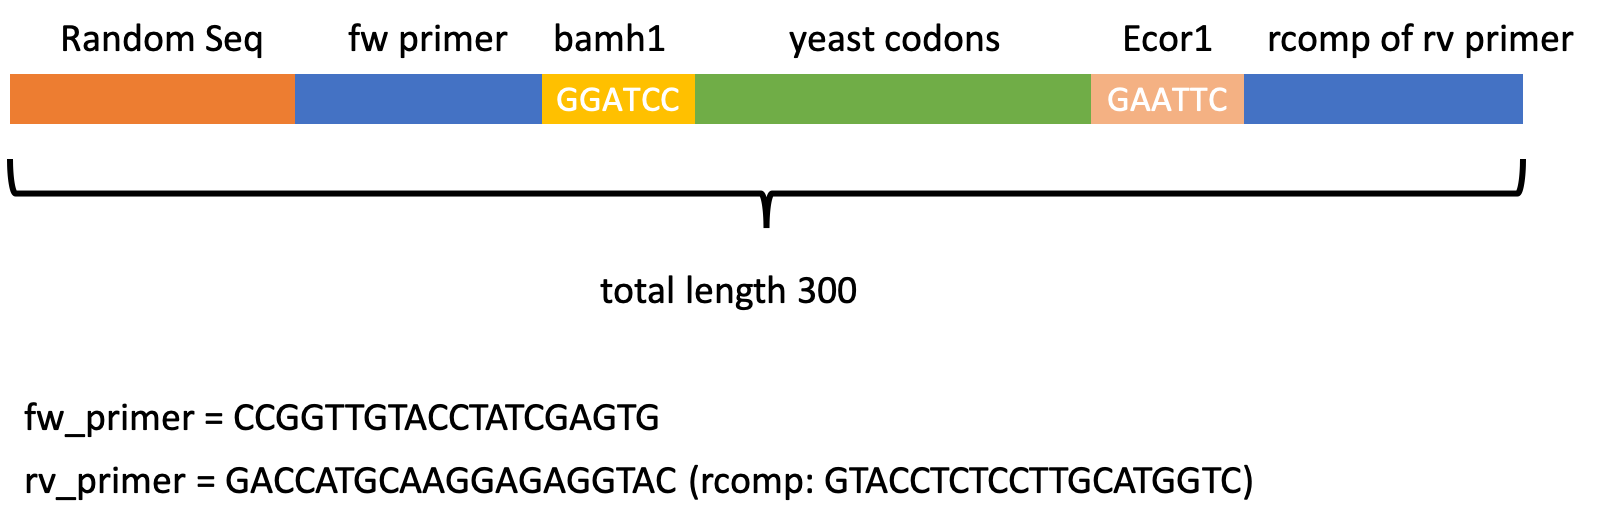

In [17]:
Image(filename='oligos300mer.png') 

In [18]:
fw_assembly_p = 'CCGGTTGTACCTATCGAGTG'+'GGATCC' # bamH1 + forward primer
rv_assembly_p = 'GAATTC'+'GTACCTCTCCTTGCATGGTC' # EcoR1 + reverse component of reverse primer

resites={'GGATCC','GAATTC','AAAAA','GGGGG','CCCCC','TTTTT'}; # BamH1, EcoR1 and replicating pattern

In [19]:
gene_design, problematic_index = [], []
global_rand = 1
for i in range(Nm):
    gene_tmp, flag, gene_ind, pro_ind = '', 0, 0, 0 
    # Initially flag=0, if sampled gene is problematic flag=1, if it's good flag=2
    avoid_homology_para = 0
    for j in range(len(protein[i])):
        if protein[i][j] == '-':
            pass
        elif protein[i][j] != ref[i][j] or avoid_homology_para == 5: 
            # Sample a new codon if AA don't match at the position.
            # protein[i]: i th designed protein
            # ref[i]: top hit natural protein of i th designed protein, according to blast result
            gene_tmp += sampling(protein[i][j], TransDict, global_rand) 
            global_rand += 1 
            # Use a global random number to get different sampled codon every time.
            # here the randomseed=0 problem should be solved.
            avoid_homology_para = 0
            # avoid_homology_para is a parameter to avoid homology caused by multiple designed seqs are
            # "mutated" from one natural allele. after each 5 continuous codons same with the natural allele,
            # it makes the 6th to be a newly sampled codon.
        else:
            gene_tmp += gene_split[i][gene_ind] # use the original codon if match
            avoid_homology_para += 1
        if ref[i][j] != '-': # skip gaps
            gene_ind += 1
        if protein[i][j] != '-':
            pro_ind += 1
        gene_tmp = gene_tmp.replace('U','T') # replace codon to gene
        
    # Special treatment to terminals of the gene to avoid unwanted RE sites at terminals.
    # This check is specific for BamHI and EcoRI. Should be modified for other RE sites.
    
    if protein[i].replace('-','')[0] == 'T':
        gene_tmp = 'ACA' + gene_tmp[3:]
    if protein[i].replace('-','')[0] == 'P':
        gene_tmp = 'CCG' + gene_tmp[3:]
    if protein[i].replace('-','')[-1] == 'S':
        gene_tmp = gene_tmp[:-3]+'AGC'
    if protein[i].replace('-','')[-1] == 'G':
        gene_tmp = gene_tmp[:-3]+'GGC'
        
    flag = 2
    for k in resites:
        if k in gene_tmp:
            flag, modify_pos = 1, int(gene_tmp.find(k)/3)
            break
            
    randseed = 1
    while flag ==1: # Correct problematic sequences by resampling
        gene_fix, pro_ind = '', 0
        left, right = int(modify_pos!=0), int(modify_pos<len(gene_tmp)-1) # if it's a terminal position
        for j in range(len(protein[i])):
            if pro_ind in np.arange(modify_pos-left,modify_pos+right+1):
                gene_fix += sampling(protein[i][j], TransDict, randseed+global_rand) # resampling
                #print(i,j,randseed)
            if protein[i][j] != '-':
                pro_ind += 1
        gene_tmp = gene_tmp[:(modify_pos-left)*3] + gene_fix + gene_tmp[(modify_pos+right+1)*3:]
        gene_tmp = gene_tmp.replace('U','T')
        
        # Redo the treatment for terminal positions... 
        if protein[i].replace('-','')[0] == 'T':
            gene_tmp = 'ACA' + gene_tmp[3:]
        if protein[i].replace('-','')[0] == 'P':
            gene_tmp = 'CCG' + gene_tmp[3:]
        if protein[i].replace('-','')[-1] == 'S':
            gene_tmp = gene_tmp[:-3]+'AGC'
        if protein[i].replace('-','')[-1] == 'G':
            gene_tmp = gene_tmp[:-3]+'GGC'
        
        flag = 2
        for k in resites: # Check again
            if k in gene_tmp:
                flag, modify_pos = 1, int(gene_tmp.find(k)/3)
                randseed +=1
                global_rand+=1
                break
        if randseed > 80:
            flag = 2
            for k in resites:
                if k in gene_tmp:
                    problematic_index.append(i)
                    break
    gene_design.append(gene_tmp)
    if i%1000 == 0 and i!=0:
        print('%d finished...' %i)
print('Finished!')

Finished!


In [20]:
print('There are %d problematic sequences.' %len(problematic_index))

There are 0 problematic sequences.


In [21]:
# Append the RE site + primer sequences to the genes
gene_design_fill = []
for i in gene_design:
    gene_design_fill.append(fw_assembly_p + i + rv_assembly_p)

3. Generated random pudding sequences and append to the beginning to fill the gene to 300mers.

* Or 250mers if all of your SH3 genes are <= (250 - 52)/3 = 66 amino acids. View Twist Price policy.

In [22]:
# length of random sequences
def gen_randseq(gene):
    len_randseq = []
    for i in gene:
        len_randseq.append(fill_to - len(i))

    print('Generating random sequences...')
    randseed = 0
    randseq_list_fill = []
    for i in len_randseq:
        flag = 0
        while flag == 0:
            np.random.seed(randseed)
            randseq = ''.join(['ACTG'[j] for j in np.random.randint(0,4,i)])

            flag = 1
            for k in resites:
                if k in randseq or k[:2] in randseq[-5:]:
                    flag = 0
                    randseed +=1
                    break
        randseq_list_fill.append(randseq)
        randseed +=1
    return randseq_list_fill

def append_rand_seq(randlist, gene):
    gene_fill_final = []
    print('Appending random sequences...')
    for i in range(len(gene)):
        gene_fill_final.append(randlist[i]+gene[i])
    return gene_fill_final

In [23]:
randseq_list_fill = gen_randseq(gene_design_fill)
gene_fill_final = append_rand_seq(randseq_list_fill, gene_design_fill)
print('Finished!')

Generating random sequences...
Appending random sequences...
Finished!


4. Write down the   
  * Final list of designed proteins in the library
  * Final list of the filled oligos (250 or 300mer)

In [24]:
with open('Outputs/Final_New_Proteins_tosubmit.fasta', 'w') as f:
    for i,item in enumerate(seqkeep):
        f.write(">%s\n" %headkeep[i])
        f.write("%s\n" %seqkeep[i])

In [25]:
with open('Outputs/oligo_fill.an', 'w') as f:
    for i,item in enumerate(gene_fill_final):
        f.write(">%s\n" %headkeep[i])
        f.write("%s\n" %item)

In [26]:
print('Writing excel file...')
oligo = pd.DataFrame(data={'header': headkeep,'gene':gene_fill_final})
oligo.to_excel('Outputs/oligo_fill.xlsx')

Writing excel file...


## Check the final oligo

Make sure of everything!  
1. Check oligo structure

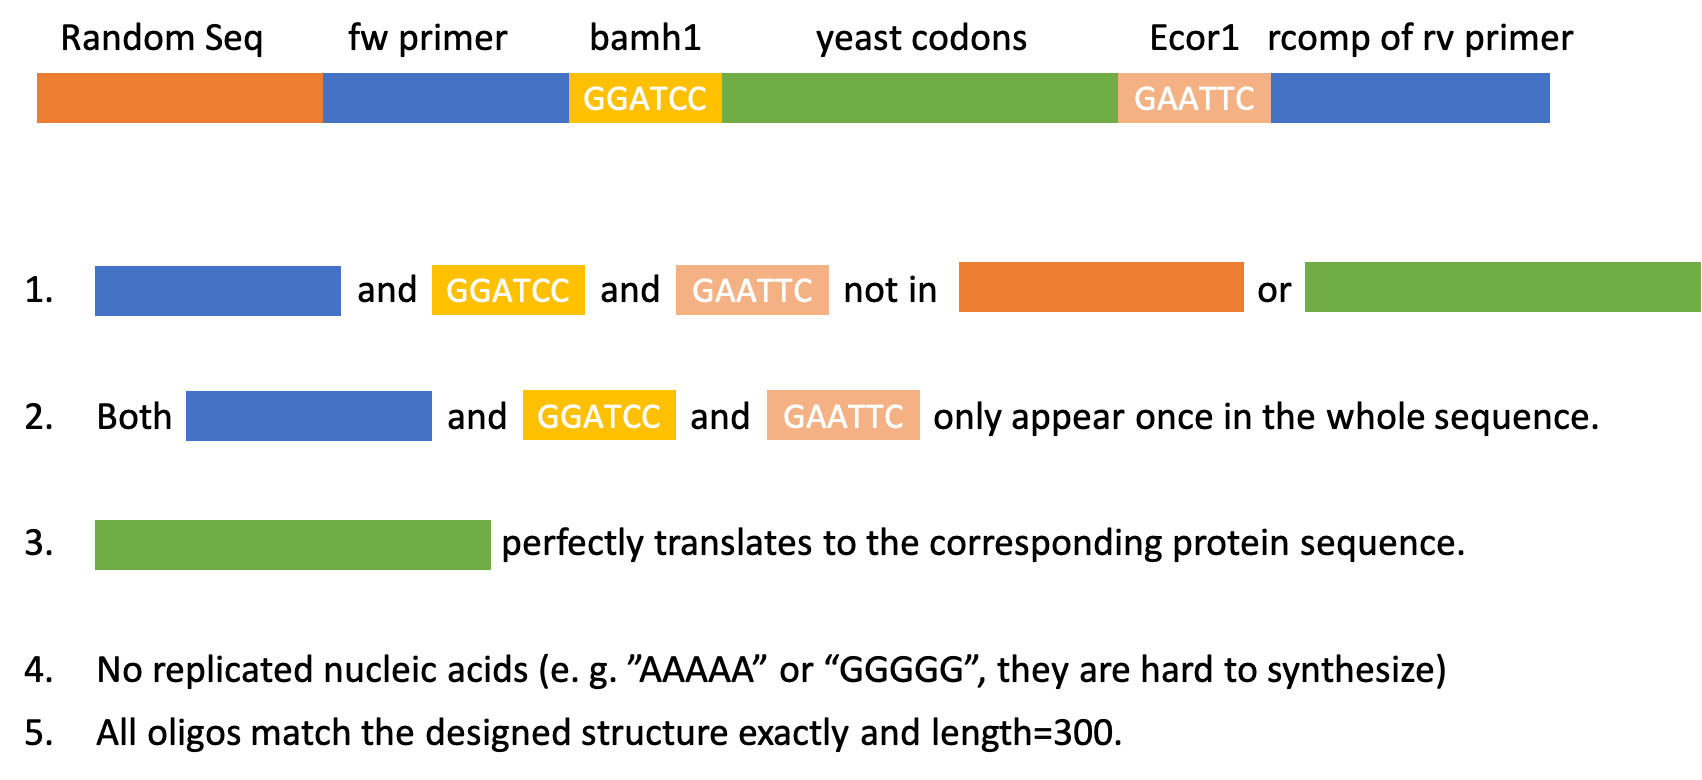

In [27]:
Image(filename='seq_structure_check.png') 

In [28]:
tmp = pd.read_excel('Outputs/oligo_fill.xlsx')
tmp_protein = get_seq('Outputs/Final_New_Proteins_tosubmit.fasta')
oligolist = tmp.gene

In [29]:
frag_digest = []
for i in range(len(oligolist)):
    oligo = oligolist[i]
    frag_digest.append\
    (oligo[oligo.find('CCGGTTGTACCTATCGAGTGGGATCC')+26 : oligo.find('GAATTCGTACCTCTCCTTGCATGGTC')])

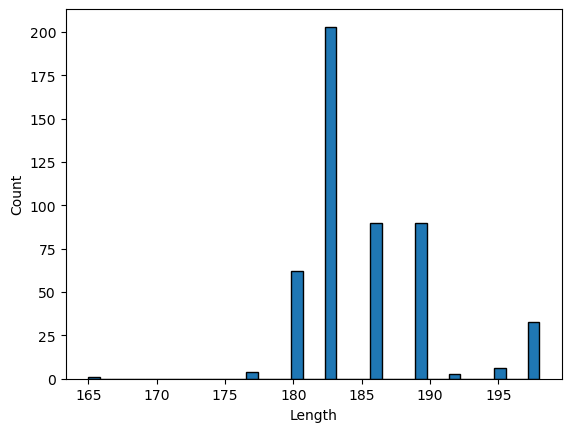

In [30]:
# oligo length after digestion. check if (length % 3 == 0)

a = [len(i) for i in frag_digest]
plt.hist(a,40,edgecolor='k')
plt.xlabel('Length')
plt.ylabel('Count')
plt.show()

In [31]:
for i in range(len(oligolist)):
    assert len(oligolist[i]) == fill_to
    
    # check if there is no RE sites, primers, replicated AAs in the oligos
    for j in ['GGATCC', 'GAATTC', 'CCGGTTGTACCTATCGAGTGG', 'GTACCTCTCCTTGCATGGTC']:
        assert oligolist[i].count(j)==1,i
    for j in ['GGGGG','AAAAA','TTTTT','CCCCC','GACCATGCAAGGAGAGGTAC','CCACTCGATAGGTACAACCGG']:
        assert j not in oligolist[i]
        
    oligo = oligolist[i]
    frag_digest = oligo[oligo.find('CCGGTTGTACCTATCGAGTGGGATCC')+26 : oligo.find('GAATTCGTACCTCTCCTTGCATGGTC')]
    translate = Seq(frag_digest).translate()
    
    assert len(frag_digest)%3 ==0
    assert str(translate) == str(tmp_protein[i])#.replace('-','') # translated match protein

In [33]:
for num, i in enumerate(oligolist[:-4]):
    for j in ['CGGTTGTACCTATCGAGT','ACCATGCAAGGAGAGGTA','TACCTCTCCTTGCATGGT','ACTCGATAGGTACAACCG']:
        for k in range(1,17):
            for h in ['A','C','T','G','AA','AC','AT','AG','CA','CC','CT','CG',
                      'TA','TC','TT','TG','GA','GC','GT','GG']:
                check_length = len(randseq_list_fill[num]) + 18
                assert j[:k]+h+j[k+1:] not in str(i)[:check_length],i

2. GC ratio

Max GC ratio = 0.58; Min GC ratio = 0.39


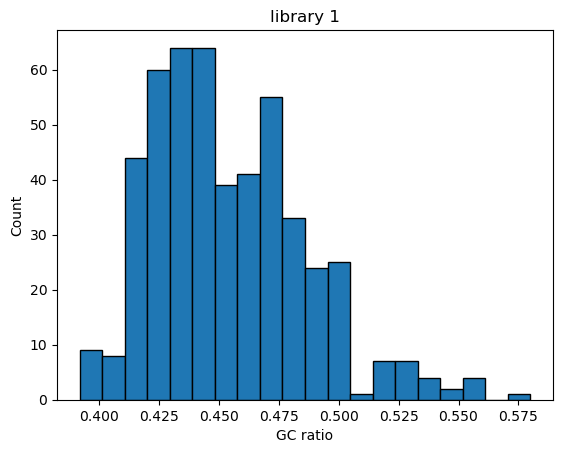

In [34]:
gc_ratio = []
for i in oligolist:
    r=(i.count('G')+i.count('C'))/fill_to
    gc_ratio.append(r)
    if r==0:
        print(i)
        break
plt.hist(gc_ratio,20,edgecolor='k')
print('Max GC ratio = %.2f; Min GC ratio = %.2f' % (max(gc_ratio),min(gc_ratio)) )
plt.title('library 1')
plt.xlabel('GC ratio')
plt.ylabel('Count')
plt.show()

3. Codon usage

In [35]:
frag_digest=[]
gene_split_new = []
for num, i in enumerate(oligolist):
    frag_digest.append(i[i.find('CCGGTTGTACCTATCGAGTGGGATCC')+26 : i.find('GAATTCGTACCTCTCCTTGCATGGTC')])
    length = int(len(frag_digest[num])/3)
    for j in range(length):
        gene_split_new.append(frag_digest[num][j*3:j*3+3])

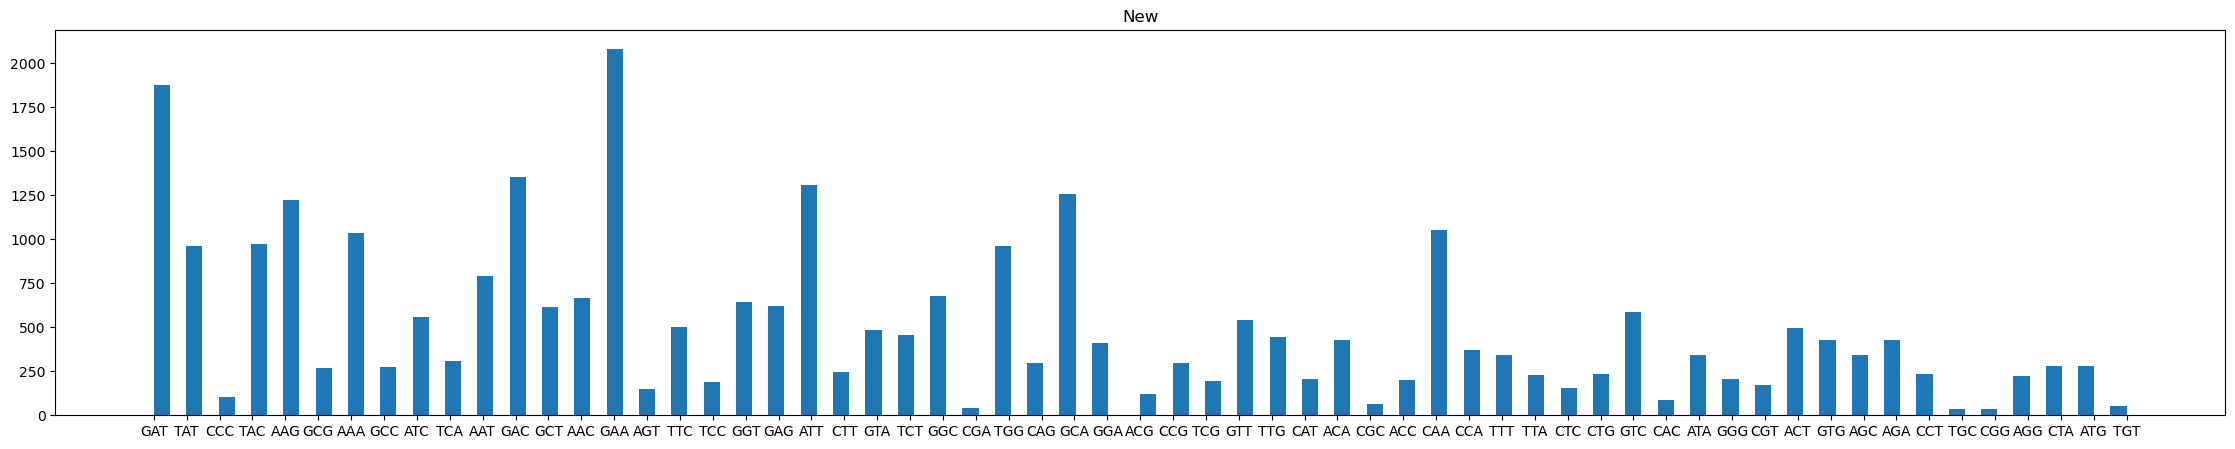

In [36]:
plt.figure(figsize=[28,5])
plt.hist(gene_split_new,bins=122)
plt.title('New')
plt.show()

In [37]:
gene_split_nat = [item for sublist in gene_split for item in sublist]

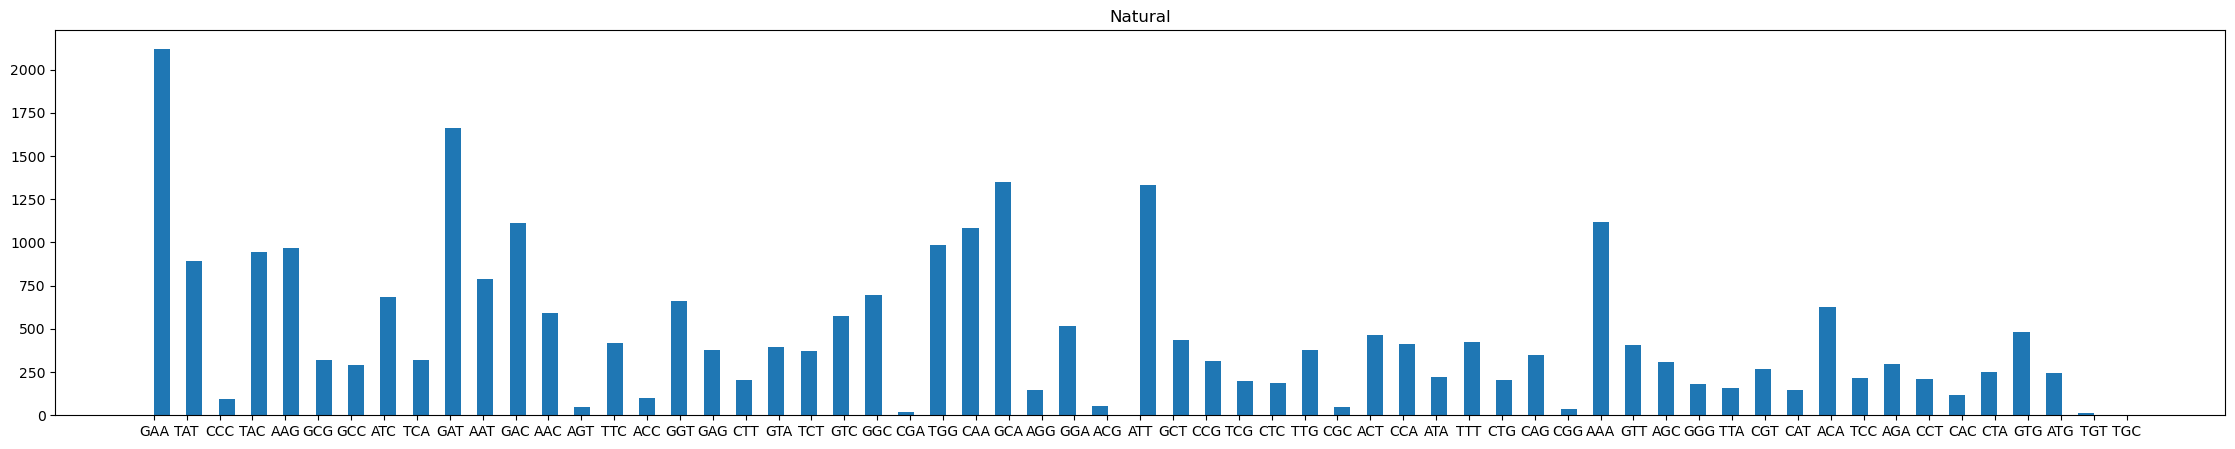

In [38]:
plt.figure(figsize=[28,5])
plt.hist(gene_split_nat,bins=122)
plt.title('Natural')
plt.show()

In [39]:
from collections import Counter
a=Counter(gene_split_nat)
b=Counter(gene_split_new)

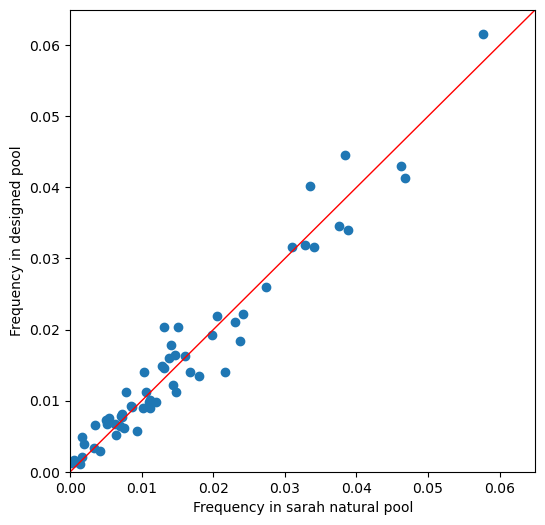

In [40]:
plt.figure(figsize=[6,6])
plt.scatter([i[1]/sum([i[1] for i in a.items()]) for i in sorted(a.items())],
            [i[1]/sum([i[1] for i in b.items()]) for i in sorted(b.items())])
plt.plot([0,0.065],[0,0.065],'r',lw=1)
plt.xlabel('Frequency in sarah natural pool')
plt.ylabel('Frequency in designed pool')
plt.xlim([0,0.065])
plt.ylim([0,0.065])
plt.show()